# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()

In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

In [4]:
#trying to shift these 1h backwards
hour_cols = [
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Index([118668], dtype='int64')
136244


Same problem for B-set at `2022-05-02 21:00:00` and C-set at `2022-04-25 21:00:00`

In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


In [7]:
# for col in hour_cols:
#     XTRA[col].shift(-4)
#     XTRB[col].shift(-4)
#     XTRB[col].shift(-4)

## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218]
[327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

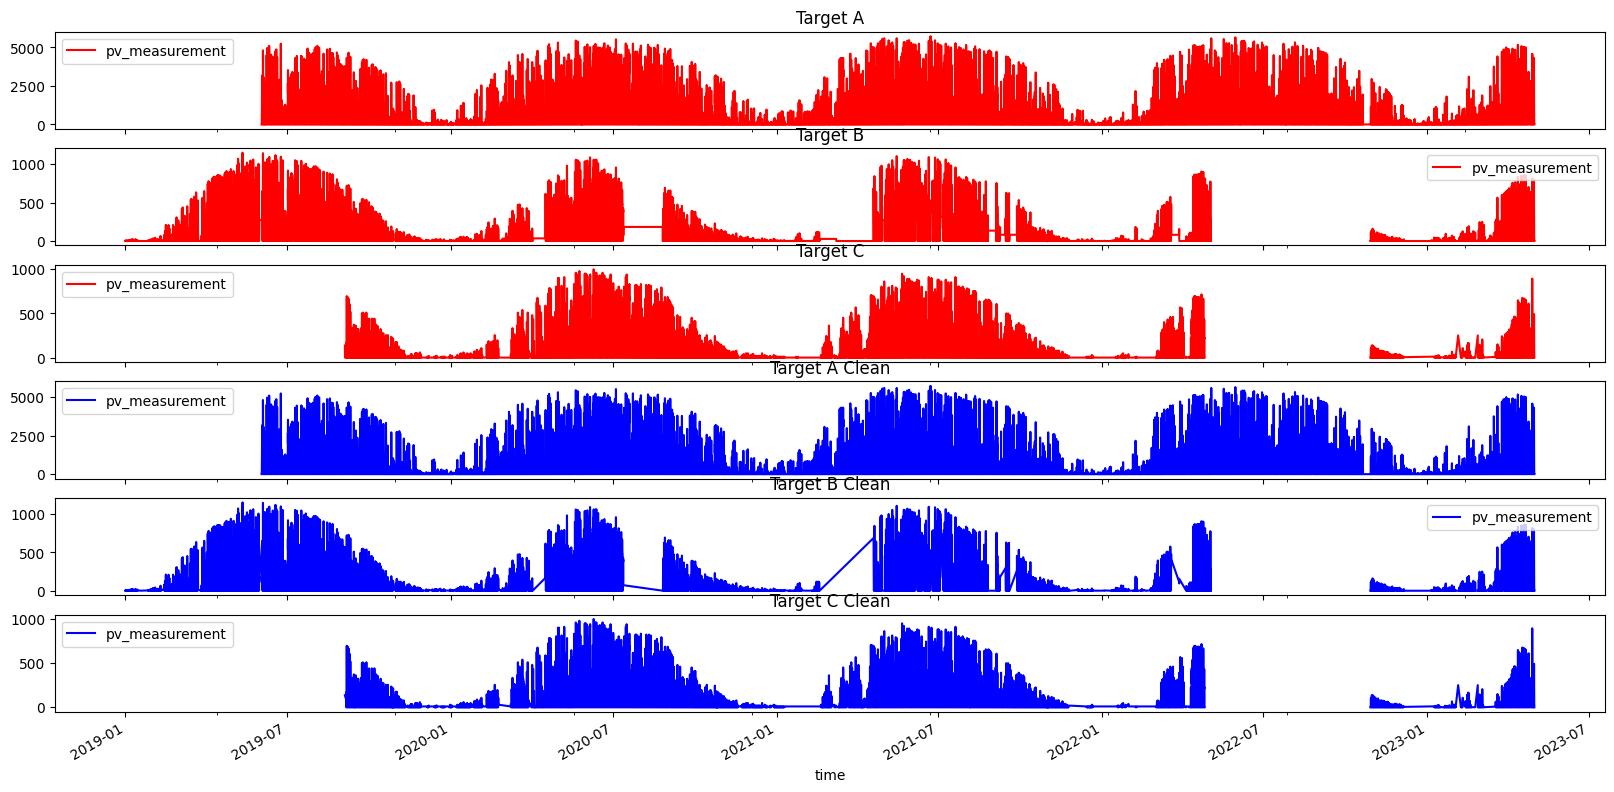

In [8]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
            zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [9]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [10]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34018 34018
x,y:  25715 25715
x,y:  21068 21068


In [11]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34013   2023-04-30 19:00:00
34014   2023-04-30 20:00:00
34015   2023-04-30 21:00:00
34016   2023-04-30 22:00:00
34017   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
25710   2023-04-30 19:00:00
25711   2023-04-30 20:00:00
25712   2023-04-30 21:00:00
25713   2023-04-30 22:00:00
25714   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
21063   2023-04-30 19:00:00
21064   2023-04-30 20:00:00
21065   2023-04-30 21:00:00
21066   2023-04-30 22:00:00
21067   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]


# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), axis=0, ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i]['above_298_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_frames_test[i]['above_298_kelvin'] = np.where(X_frames_test[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
     X_frames_test[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True) # Negligable??
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


Combine features

In [13]:
def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
    X_train[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])
    X_frames_test[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])

Multiply Cloud_coverage's flipped values with clear_sky_energy

In [14]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_rad:W']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_rad:W']

    X_train[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])

In [15]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test[i].drop(columns=['air_density_2m:kgm3'], inplace=True)

In [16]:
# sumarizing direct and diffuse rad:
for i in range(len(X_train)):
    X_train[i]['total_rad_1h:J'] = X_train[i]['direct_rad_1h:J']+X_train[i]['diffuse_rad_1h:J']
    X_train[i]['total_rad:w'] = X_train[i]["diffuse_rad:W"] + X_train[i]["direct_rad:W"]
    X_frames_test[i]['total_rad_1h:J'] = X_frames_test[i]['direct_rad_1h:J']+ X_frames_test[i]['diffuse_rad_1h:J']
    X_frames_test[i]['total_rad:w'] = X_frames_test[i]["diffuse_rad:W"] + X_frames_test[i]["direct_rad:W"]
    #X_frames_test[i].drop(columns=["diffuse_rad:W", "direct_rad:W", 'direct_rad_1h:J', 'diffuse_rad_1h:J'])
    

In [17]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['ceiling_height_agl:m'].max())
    print(i, X_train[i]['ceiling_height_agl:m'].max())

0 11430.775
0 12294.901
1 11430.9
1 12285.775
2 11468.0
2 12260.225


Flipping this as well and replacing null with 0 might give better result. For instance null = no cluds, and by flipping the values we say that taller clouds are closer to no clouds than lower clouds. As in the real world. Simply using the highest measured ceiling height as flipping value and adding 1000 to differentiate from no clouds 

> (e.g. 100 gets flipped to 100-(max_height+1000))

In [18]:
X_train[i]['ceiling_height_agl:m'].tail(20)

21048    4022.100342
21049    4189.450195
21050    4583.450195
21051    4099.325195
21052    2434.050049
21053    1396.125000
21054    1260.025024
21055    1854.625000
21056    2856.574951
21057    3968.550049
21058    4919.075195
21059    4533.200195
21060    3356.399902
21061    2030.000000
21062    1943.750000
21063    1456.574951
21064    1476.349976
21065    1516.300049
21066    1240.599976
21067    1484.500000
Name: ceiling_height_agl:m, dtype: float32

In [19]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train)):
    X_frames_test[i]['ceiling_height_agl:m'] = X_frames_test[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train[i]['ceiling_height_agl:m']= X_train[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)

In [20]:
X_train[i]['ceiling_height_agl:m'].isna().sum()

4383

In [21]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['cloud_base_agl:m'].max())
    print(i, X_train[i]['cloud_base_agl:m'].max())

0 11256.7
0 11673.625
1 11256.8
1 11259.0
2 11467.8
2 11652.7


In [22]:
X_train[i]['cloud_base_agl:m'].tail(20)

21048     806.500000
21049     956.349976
21050    1151.574951
21051    1044.550049
21052     715.775024
21053     630.724976
21054     496.049988
21055     325.625000
21056     428.025024
21057     617.549988
21058     689.174988
21059     716.650024
21060     693.300049
21061     620.349976
21062     568.099976
21063     551.224976
21064     564.099976
21065     578.700012
21066     551.500000
21067     558.674988
Name: cloud_base_agl:m, dtype: float32

In [23]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train)):
    X_frames_test[i]['cloud_base_agl:m'] = X_frames_test[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train[i]['cloud_base_agl:m']= X_train[i]['cloud_base_agl:m'].apply(flip_ceiling_height)

In [24]:
X_train[i]['cloud_base_agl:m'].isna().sum()

1857

In [25]:
print(X_frames_test[0].columns)

Index(['is_day:idx', 'is_in_shadow:idx', 'ceiling_height_agl:m',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa',
       'precip_5min:mm', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_d

## Data Cleaning

In [26]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6127,4096,4383
cloud_base_agl:m,2363,1843,1857
snow_density:kgm3,32878,24842,21010


In [27]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [28]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

In [29]:
drop_cols_a = [
    "fresh_snow_12h:cm", 
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_drift:idx",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2"
]

X_train[0].drop(columns=drop_cols_a, inplace=True)
X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

# Training the model

In [30]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)

In [31]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined_a = pd.merge(x_train_a, y_train_a, left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, presets='medium_quality', time_limit=300) #, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231110_114613"
Presets specified: ['medium_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20231110_114613"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   367.17 GB / 994.66 GB (36.9%)
Train Data Rows:    28234
Train Data Columns: 52
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.f

[1000]	valid_set's l1: 172.518
[2000]	valid_set's l1: 165.899
[3000]	valid_set's l1: 162.432
[4000]	valid_set's l1: 160.226
[5000]	valid_set's l1: 159.053
[6000]	valid_set's l1: 158.261
[7000]	valid_set's l1: 157.693
[8000]	valid_set's l1: 157.228
[9000]	valid_set's l1: 156.68
[10000]	valid_set's l1: 156.256


	-156.2556	 = Validation score   (-mean_absolute_error)
	42.73s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 253.81s of the 253.8s of remaining time.


[1000]	valid_set's l1: 172.456
[2000]	valid_set's l1: 168.567
[3000]	valid_set's l1: 167.517
[4000]	valid_set's l1: 167.187
[5000]	valid_set's l1: 166.891
[6000]	valid_set's l1: 166.784
[7000]	valid_set's l1: 166.731
[8000]	valid_set's l1: 166.648
[9000]	valid_set's l1: 166.614
[10000]	valid_set's l1: 166.588


	-166.587	 = Validation score   (-mean_absolute_error)
	43.85s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 209.29s of the 209.29s of remaining time.
	-186.8519	 = Validation score   (-mean_absolute_error)
	20.63s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 188.43s of the 188.43s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 188.32s of the 188.32s of remaining time.
	-187.6495	 = Validation score   (-mean_absolute_error)
	3.02s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 185.04s of the 185.04s of remaining time.
	-187.4843	 = Validation score   (-mean_absolute_error)
	16.67s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 168.35s of the 168.35s of remaining time.
		'Booster' object has no attribute 'best_ntre

In [32]:
y_a_test = predictor.predict(x_val_a)

In [33]:
join_val_a = pd.merge(x_val_a, y_val_a, left_index=True, right_index=True)
predictor.leaderboard(join_val_a, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-156.817292,-155.108861,1.554030,0.598411,100.163996,0.001012,0.000181,0.088477,2,True,9
1,LightGBMXT,-158.645371,-156.255586,0.702266,0.249428,42.725626,0.702266,0.249428,42.725626,1,True,3
2,LightGBM,-166.739463,-166.587040,0.827959,0.325842,43.852668,0.827959,0.325842,43.852668,1,True,4
3,NeuralNetTorch,-177.664325,-177.582103,0.022793,0.022960,13.497225,0.022793,0.022960,13.497225,1,True,8
4,RandomForestMSE,-183.582340,-186.851864,0.200113,0.039328,20.633109,0.200113,0.039328,20.633109,1,True,5
5,NeuralNetFastAI,-184.978294,-187.484349,0.084398,0.014730,16.666075,0.084398,0.014730,16.666075,1,True,7
6,ExtraTreesMSE,-186.799970,-187.649533,0.193464,0.039972,3.023464,0.193464,0.039972,3.023464,1,True,6
7,KNeighborsUnif,-262.984063,-260.805961,0.427309,0.361751,2.306284,0.427309,0.361751,2.306284,1,True,1
8,KNeighborsDist,-263.133912,-262.103923,0.154882,0.062369,0.018598,0.154882,0.062369,0.018598,1,True,2


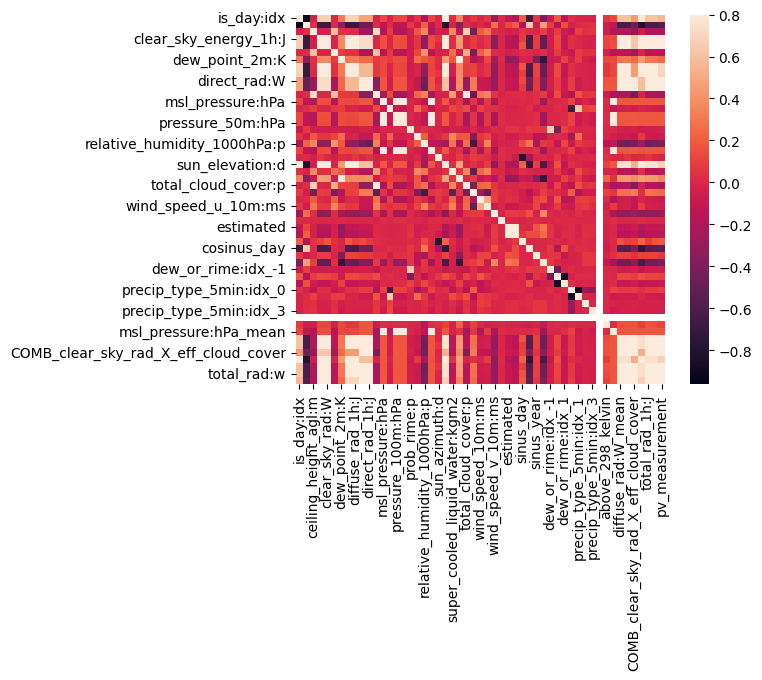

In [34]:
import seaborn as sb
cm = joined_a.corr()
fig = plt.figure()
sb.heatmap(cm, vmax=0.8, square=True)
plt.show()

In [35]:
joined_b = pd.merge(x_train_b, y_train_b, left_index=True, right_index=True)
train_b = TabularDataset(joined_b)
predictor_b = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_b,  presets='medium_quality', time_limit=300)#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231110_115118"
Presets specified: ['medium_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20231110_115118"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   366.33 GB / 994.66 GB (36.8%)
Train Data Rows:    21343
Train Data Columns: 60
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.f

[1000]	valid_set's l1: 24.4031
[2000]	valid_set's l1: 23.5253
[3000]	valid_set's l1: 23.002
[4000]	valid_set's l1: 22.8268
[5000]	valid_set's l1: 22.7001
[6000]	valid_set's l1: 22.6125
[7000]	valid_set's l1: 22.5576
[8000]	valid_set's l1: 22.5122
[9000]	valid_set's l1: 22.4965
[10000]	valid_set's l1: 22.4842


	-22.484	 = Validation score   (-mean_absolute_error)
	123.67s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 175.31s of the 175.31s of remaining time.


[1000]	valid_set's l1: 24.5123
[2000]	valid_set's l1: 24.0105
[3000]	valid_set's l1: 23.8734
[4000]	valid_set's l1: 23.795
[5000]	valid_set's l1: 23.7524
[6000]	valid_set's l1: 23.7402
[7000]	valid_set's l1: 23.733
[8000]	valid_set's l1: 23.7295
[9000]	valid_set's l1: 23.7239
[10000]	valid_set's l1: 23.7214


	-23.7214	 = Validation score   (-mean_absolute_error)
	45.84s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 128.84s of the 128.84s of remaining time.
	-27.4219	 = Validation score   (-mean_absolute_error)
	13.83s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 114.85s of the 114.85s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 114.75s of the 114.74s of remaining time.
	-27.4834	 = Validation score   (-mean_absolute_error)
	2.28s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 112.27s of the 112.27s of remaining time.
	-26.7178	 = Validation score   (-mean_absolute_error)
	10.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 101.96s of the 101.96s of remaining time.
		'Booster' object has no attribute 'best_ntree_l

In [36]:
y_b_test = predictor_b.predict(x_val_b)

In [37]:
join_val_b = pd.merge(x_val_b, y_val_b, left_index=True, right_index=True)
predictor_b.leaderboard(join_val_b, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-22.218407,-22.305990,1.250128,0.547912,179.875611,0.000831,0.000187,0.080256,2,True,8
1,LightGBMXT,-22.395202,-22.483959,0.530653,0.252532,123.673095,0.530653,0.252532,123.673095,1,True,3
2,LightGBM,-23.457692,-23.721389,0.676926,0.284430,45.836216,0.676926,0.284430,45.836216,1,True,4
3,NeuralNetFastAI,-26.120431,-26.717798,0.041718,0.010763,10.286044,0.041718,0.010763,10.286044,1,True,7
4,RandomForestMSE,-26.605567,-27.421921,0.136918,0.039772,13.833070,0.136918,0.039772,13.833070,1,True,5
5,ExtraTreesMSE,-26.875000,-27.483398,0.120959,0.040071,2.282912,0.120959,0.040071,2.282912,1,True,6
6,KNeighborsDist,-41.378928,-43.740804,0.109361,0.203186,0.018916,0.109361,0.203186,0.018916,1,True,2
7,KNeighborsUnif,-41.468579,-43.661301,0.109248,0.049262,0.015470,0.109248,0.049262,0.015470,1,True,1


In [38]:
joined_c = pd.merge(x_train_c, y_train_c, left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, presets='medium_quality', time_limit=300)#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231110_115621"
Presets specified: ['medium_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20231110_115621"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   365.76 GB / 994.66 GB (36.8%)
Train Data Rows:    17486
Train Data Columns: 60
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.f

[1000]	valid_set's l1: 22.4929
[2000]	valid_set's l1: 21.7629
[3000]	valid_set's l1: 21.3387
[4000]	valid_set's l1: 21.1527
[5000]	valid_set's l1: 21.051
[6000]	valid_set's l1: 21.0017
[7000]	valid_set's l1: 20.9626
[8000]	valid_set's l1: 20.9384
[9000]	valid_set's l1: 20.9273
[10000]	valid_set's l1: 20.915


	-20.9142	 = Validation score   (-mean_absolute_error)
	123.12s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 176.08s of the 176.08s of remaining time.


[1000]	valid_set's l1: 22.7996
[2000]	valid_set's l1: 22.5462
[3000]	valid_set's l1: 22.4625
[4000]	valid_set's l1: 22.4161
[5000]	valid_set's l1: 22.3924
[6000]	valid_set's l1: 22.3823
[7000]	valid_set's l1: 22.3829


	-22.3798	 = Validation score   (-mean_absolute_error)
	34.27s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 141.47s of the 141.47s of remaining time.
	-24.8167	 = Validation score   (-mean_absolute_error)
	11.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 129.92s of the 129.92s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 129.83s of the 129.83s of remaining time.
	-24.8103	 = Validation score   (-mean_absolute_error)
	1.71s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 127.93s of the 127.93s of remaining time.
	-23.536	 = Validation score   (-mean_absolute_error)
	8.2s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 119.71s of the 119.71s of remaining time.
		'Booster' object has no attribute 'best_ntree_limit

In [39]:
y_c_test = predictor_c.predict(x_val_c)

In [40]:
join_val_c = pd.merge(x_val_c, y_val_c, left_index=True, right_index=True)
predictor_c.leaderboard(join_val_c, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-20.186611,-20.705364,0.548896,0.214382,141.850416,0.002588,0.000176,0.088610,2,True,9
1,LightGBMXT,-20.361617,-20.914212,0.483411,0.194655,123.122353,0.483411,0.194655,123.122353,1,True,3
2,LightGBM,-21.687487,-22.379822,0.283214,0.150807,34.272329,0.283214,0.150807,34.272329,1,True,4
3,NeuralNetTorch,-22.984265,-23.107006,0.019370,0.010868,10.440223,0.019370,0.010868,10.440223,1,True,8
4,NeuralNetFastAI,-24.073264,-23.536030,0.043527,0.008683,8.199231,0.043527,0.008683,8.199231,1,True,7
5,ExtraTreesMSE,-24.167462,-24.810272,0.101312,0.039807,1.708881,0.101312,0.039807,1.708881,1,True,6
6,RandomForestMSE,-24.168985,-24.816701,0.107815,0.039738,11.397428,0.107815,0.039738,11.397428,1,True,5
7,KNeighborsUnif,-33.701813,-34.528779,0.111282,0.049136,0.016484,0.111282,0.049136,0.016484,1,True,1
8,KNeighborsDist,-33.702533,-34.533067,0.097012,0.065231,0.013067,0.097012,0.065231,0.013067,1,True,2


## Evaluate

In [41]:
from sklearn.metrics import mean_absolute_error
mae_a = mean_absolute_error(y_val_a, predictor.predict(x_val_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, y_b_test)
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, y_c_test)
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

MAE for A:  156.81729202499562
MAE for B:  22.218407146967714
MAE for C:  20.186610653452934
Mean MAE:  66.40743660847208


(fjernet radiation og clearsky energy med scoren under)

MAE for A:  156.81729202499562
MAE for B:  22.218407146967714
MAE for C:  20.208044695039092
Mean MAE:  66.41458128900081

In [33]:
# x_val_a

In [34]:
full_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
full_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
full_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)

In [35]:
pred = predictor.predict(X_train[0][34000:34025])

In [36]:
goal = Y_train[0][34000:34025]

In [37]:
g=34000
print(pred[34000])
for i in range(len(pred)):
    print(i, pred[i+g]-goal[i+g], pred[i+g], goal[i+g])

855.8206
0 -221.29938232421864 855.8206 1077.12
1 18.91958007812491 1486.3196 1467.4
2 -460.65625 4120.8438 4581.5
3 82.97738769531247 1221.6974 1138.72
4 -21.481171874999973 1281.7988 1303.28
5 38.22955078124983 1280.7896 1242.5600000000002
6 -30.913232421875023 778.68677 809.6
7 -25.267296142578118 278.5527 303.82
8 12.280349731445312 34.28035 22.0
9 17.357450485229492 17.35745 0.0
10 17.72382354736328 17.723824 0.0
11 17.690614700317383 17.690615 0.0
12 17.777938842773438 17.777939 0.0
13 17.626474380493164 17.626474 0.0
14 17.462055206298828 17.462055 0.0
15 16.612483978271484 16.612484 0.0
16 0.07876983642578494 43.41877 43.339999999999996
17 -18.932384033203107 138.58762 157.51999999999998
18 -46.456573486328125 256.04343 302.5
19 64.49330810546877 387.4533 322.96
20 -7.683834228515593 471.47617 479.15999999999997
21 28.764296875000014 674.9043 646.14
22 -7.923549804687468 894.73645 902.66
23 3.1628320312497635 1084.9028 1081.7400000000002
24 -10.7020117187501 1333.938 1344.64


In [38]:
print(goal[11+g], pred[11+g])

0.0 17.690615


In [39]:
#X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

In [40]:
test_pred = predictor.transform_features(X_frames_test[0][0:25])

In [41]:
predictor.predict(test_pred)

34061      15.502867
34062      15.256422
34063      15.356131
34064      50.681835
34065     319.611176
34066     802.164185
34067    1696.282227
34068    3184.991455
34069    3134.169922
34070    2983.193604
34071    3639.419189
34072    3296.922852
34073    2649.825684
34074    3057.472656
34075    2572.803223
34076    1595.059082
34077    1414.158569
34078     600.350220
34079     201.429108
34080      38.868683
34081      17.521238
34082      18.215988
34083      17.210369
34084      17.085529
34085      14.099195
Name: pv_measurement, dtype: float32

In [41]:
#predictions before full training
pred_split_a = predictor.predict(X_frames_test[0])
pred_split_b = predictor_b.predict(X_frames_test[1])
pred_split_c = predictor_c.predict(X_frames_test[2])

# Make predictions

In [42]:
# Do some more stuff
y_pred = np.concatenate((pred_split_a, pred_split_b, pred_split_c), axis=0)

print(len(y_pred))

2160


In [43]:
y_pred[0:10]

array([  -4.8838625,   -9.082048 ,  -10.247913 ,   28.13417  ,
        258.2115   ,  701.33295  , 1603.6904   , 2987.644    ,
       2539.2278   , 1801.0106   ], dtype=float32)

In [44]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0

# Evaluate prediction

# Create submission

In [45]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/autogluon_med_300_full_submission.csv', index=False)

In [ ]:
combine = combined
#combine submission
res = []
comb = pd.read_csv("../best_notebooks/submissions/submission_xg.csv")
for i in range(len(comb)):
    res.append((comb["prediction"].iloc[i] + submission["prediction"].iloc[i])/2)

new_sub = pd.DataFrame()
new_sub["id"] = submission["id"]
new_sub["prediction"] = res

new_sub.to_csv("./submissions/sub_combined_ag_xg_2.csv", index = False)